In [5]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras  import losses
from keras.optimizers import Adadelta
from keras import backend as K

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline 

/home/machinator/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Read-In, Scale, and Resample Data**

In [6]:
dataDir = 'data/'
trainDir = 'train/'
train = pd.read_csv(dataDir+'creditcard.csv').values

X = train[:, :29]
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

y = train[:, 30]
fraud_count = y.sum()

X_res, y_res = RandomUnderSampler(ratio={0: int(fraud_count), 1: int(fraud_count)}).fit_resample(X_scaled, y)

**Define Functions For Precision, Recall, and F1**

In [7]:
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model = Sequential()
model.add(Dense(29, input_dim=29, kernel_initializer='random_normal', activation='relu'))
model.add(Dense(24, kernel_initializer='random_normal', activation='relu'))
model.add(Dense(16, kernel_initializer='random_normal', activation='relu'))
model.add(Dense(8, kernel_initializer='random_normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall])

**Automated Optimizer Testing Function**

In [12]:
def run_optimizerTest(optimizers=['adadelta', 'adagrad', 'adam', 'sgd', 'adamax', 'nadam'], epochs=100, batchSize=10, validationSplit=0.2, verbose=True):
    history_dict = {}
    
    # Create and train a new model for each optimizer in optimizers[]
    for optimizer in optimizers:
        model = Sequential()
        model.add(Dense(29, input_dim=29, kernel_initializer='random_normal', activation='relu'))
        model.add(Dense(24, kernel_initializer='random_normal', activation='relu'))
        model.add(Dense(16, kernel_initializer='random_normal', activation='relu'))
        model.add(Dense(8, kernel_initializer='random_normal', activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[precision, recall])
        
        # Fit model and store result in dictionary using optimizer name as key, and history as value.
        history = model.fit(X_res, y_res, epochs=epochs, batch_size=batchSize, validation_split=validationSplit, verbose=verbose)
        history_dict[optimizer] = history
    
    return(history_dict)

**History Plotter  
Group data by metric (not by model) and plot each metric in a unique subplot.**

In [13]:
def plot_history_groupbyMetric(histories, color_dict, show_precision=False, space_between=0.1, special_legend=False, legend_cols=0,  x_scale='linear', plot_size=(12, 5), primary_axis_size=1, eval_metrics=['precision', 'recall'], alignment='vertical'):
    num_plots = len(eval_metrics)
    
    if(alignment == 'vertical'):
        fig, ax = plt.subplots(nrows=num_plots, ncols=primary_axis_size, figsize=(plot_size[0], num_plots*plot_size[1]))
    else:
        fig, ax = plt.subplots(nrows=primary_axis_size, ncols=num_plots, figsize=(num_plots*plot_size[0], plot_size[1]))

    for metric_index, metric in enumerate(eval_metrics):
    
        for i, h_label in enumerate(histories):
            h = histories[h_label]

            metric_list = [s for s in h.history.keys() if metric in s and 'val' not in s]
            val_metric_list = [s for s in h.history.keys() if metric in s and 'val' in s]
            epochs = range(1,len(h.history[metric_list[0]]) + 1)

            if(show_precision):
                for r in metric_list:
                    ax[metric_index].plot(epochs, h.history[r], color_dict[h_label][0], label='Training '+str(metric)+': '+h_label.capitalize()+' (' + str(str(format(h.history[r][-1],'.5f'))+')'))
                for r in val_metric_list:
                    ax[metric_index].plot(epochs, h.history[r], color_dict[h_label][1], label='Validation '+str(metric)+': '+h_label.capitalize()+' (' + str(str(format(h.history[r][-1],'.5f'))+')'))
            else:
                for r in val_metric_list:
                    ax[metric_index].plot(epochs, h.history[r], color_dict[h_label][0], label='Validation '+str(metric)+': '+h_label.capitalize()+' (' + str(str(format(h.history[r][-1],'.5f'))+')'))
        
        ax[metric_index].set_title(metric.capitalize())
        ax[metric_index].set_xlabel('Epochs')
        ax[metric_index].set_ylabel('Metric')
        ax[metric_index].set_xscale(x_scale)
        
        if(special_legend):
            if(alignment == 'vertical'):
                box = ax[metric_index].get_position()
                ax[metric_index].set_position([box.x0, box.y0, box.width * 0.8, box.height])
                ax[metric_index].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                box = ax[metric_index].get_position()
                ax[metric_index].set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
                ax[metric_index].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=legend_cols)
                fig.subplots_adjust(wspace=0.1)
        else:
            ax[metric_index].legend()
            if(alignment=='horizontal'):
                fig.subplots_adjust(wspace=0.1)
                
    fig.show()

In [16]:
adam_sgd_results = run_optimizerTest(optimizers=['adam', 'sgd'], x_scale='log', epochs=1000, batchSize=16, verbose=False, validationSplit=0.1)

/home/machinator/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


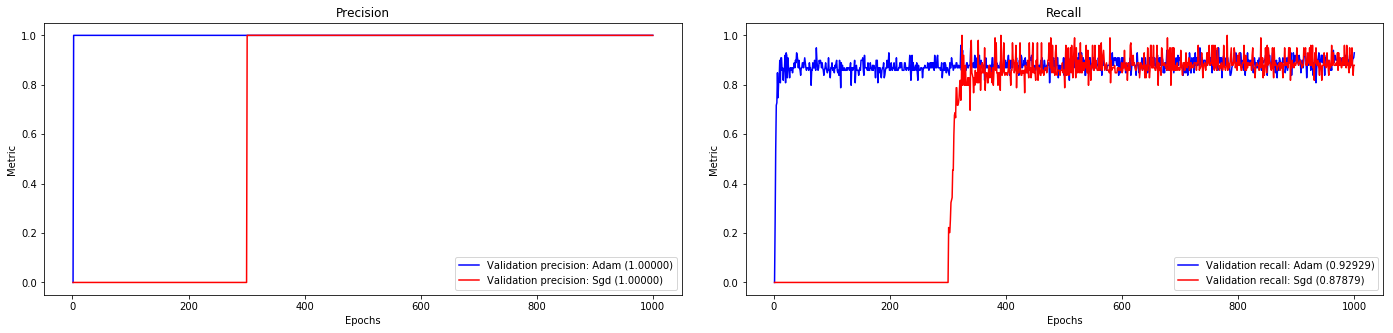

In [17]:
adam_sgd_colorDict = {'adam': ['blue', 'green'], 'sgd': ['red', 'orange']}
plot_history_groupbyMetric(adam_sgd_results, adam_sgd_colorDict, plot_size=(12, 5), alignment='horizontal')

In [19]:
adadelta_adagrad_adam_sgd_results = run_optimizerTest(optimizers=['adadelta', 'adam', 'adagrad', 'sgd'], epochs=750, batchSize=10, verbose=False, validationSplit=0.1)

/home/machinator/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


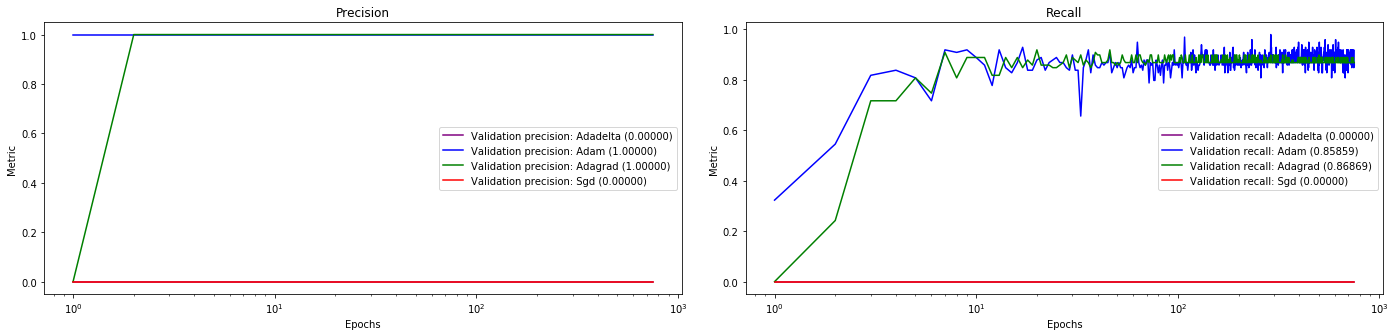

In [20]:
adadelta_adagrad_adam_sgd_colorDict = {'adam': ['blue'], 'sgd': ['red'], 'adagrad': ['green'], 'adadelta': ['purple']}
plot_history_groupbyMetric(adadelta_adagrad_adam_sgd_results, adadelta_adagrad_adam_sgd_colorDict, alignment='horizontal', x_scale='log')

In [25]:
all_ada_results = run_optimizerTest(optimizers=['adadelta', 'adam', 'adagrad', 'adamax', ], epochs=100, batchSize=10, validationSplit=0.1)

Train on 885 samples, validate on 99 samples
Epoch 1/100
885/885 [==============================] - 1s 1ms/step - loss: 0.6915 - precision: 0.0136 - recall: 0.0339 - val_loss: 0.7299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
885/885 [==============================] - 0s 179us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
885/885 [==============================] - 0s 190us/step - loss: 0.6254 - precision: 0.4028 - recall: 0.3030 - val_loss: 0.8736 - val_precision: 1.0000 - val_recall: 0.5051
Epoch 4/100
885/885 [==============================] - 0s 197us/step - loss: 0.4577 - precision: 0.8736 - recall: 0.6879 - val_loss: 0.1843 - val_precision: 1.0000 - val_recall: 0.9192
Epoch 5/100
885/885 [==============================] - 0s 185us/step - loss: 0.3023 - precision: 0.9525 - recall: 0.8233 - val_loss: 0.5253 - val_precision: 1.0000 - val_recall: 0.7273
Epoch 6/

Epoch 45/100
885/885 [==============================] - 0s 151us/step - loss: 0.1682 - precision: 0.9761 - recall: 0.8801 - val_loss: 0.2594 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 46/100
885/885 [==============================] - 0s 302us/step - loss: 0.1727 - precision: 0.9697 - recall: 0.8994 - val_loss: 0.3231 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 47/100
885/885 [==============================] - 0s 140us/step - loss: 0.1671 - precision: 0.9796 - recall: 0.8807 - val_loss: 0.4347 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 48/100
885/885 [==============================] - 0s 121us/step - loss: 0.1687 - precision: 0.9727 - recall: 0.8859 - val_loss: 0.2610 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 49/100
885/885 [==============================] - 0s 119us/step - loss: 0.1687 - precision: 0.9695 - recall: 0.8912 - val_loss: 0.3752 - val_precision: 1.0000 - val_recall: 0.8384
Epoch 50/100
885/885 [==============================] - 0s 119us/step 

885/885 [==============================] - 0s 158us/step - loss: 0.1617 - precision: 0.9759 - recall: 0.8962 - val_loss: 0.3589 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 90/100
885/885 [==============================] - 0s 114us/step - loss: 0.1638 - precision: 0.9840 - recall: 0.8823 - val_loss: 0.2575 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 91/100
885/885 [==============================] - 0s 121us/step - loss: 0.1599 - precision: 0.9761 - recall: 0.8946 - val_loss: 0.2536 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 92/100
885/885 [==============================] - 0s 271us/step - loss: 0.1604 - precision: 0.9807 - recall: 0.8941 - val_loss: 0.3208 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 93/100
885/885 [==============================] - 0s 200us/step - loss: 0.1621 - precision: 0.9761 - recall: 0.8913 - val_loss: 0.1382 - val_precision: 1.0000 - val_recall: 0.9192
Epoch 94/100
885/885 [==============================] - 0s 189us/step - loss: 0.162

Epoch 33/100
885/885 [==============================] - 0s 123us/step - loss: 0.1678 - precision: 0.9794 - recall: 0.8866 - val_loss: 0.2202 - val_precision: 1.0000 - val_recall: 0.8788
Epoch 34/100
885/885 [==============================] - 0s 113us/step - loss: 0.1687 - precision: 0.9637 - recall: 0.8912 - val_loss: 0.2119 - val_precision: 1.0000 - val_recall: 0.8990
Epoch 35/100
885/885 [==============================] - 0s 126us/step - loss: 0.1736 - precision: 0.9749 - recall: 0.8945 - val_loss: 0.3806 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 36/100
885/885 [==============================] - 0s 115us/step - loss: 0.1784 - precision: 0.9744 - recall: 0.8973 - val_loss: 0.2466 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 37/100
885/885 [==============================] - 0s 137us/step - loss: 0.1754 - precision: 0.9433 - recall: 0.8722 - val_loss: 0.2470 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 38/100
885/885 [==============================] - 0s 113us/step 

885/885 [==============================] - 0s 128us/step - loss: 0.1598 - precision: 0.9452 - recall: 0.8781 - val_loss: 0.4201 - val_precision: 1.0000 - val_recall: 0.8384
Epoch 78/100
885/885 [==============================] - 0s 132us/step - loss: 0.1622 - precision: 0.9720 - recall: 0.8781 - val_loss: 0.4672 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 79/100
885/885 [==============================] - 0s 127us/step - loss: 0.1666 - precision: 0.9685 - recall: 0.8765 - val_loss: 0.2105 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 80/100
885/885 [==============================] - 0s 120us/step - loss: 0.1654 - precision: 0.9677 - recall: 0.8985 - val_loss: 0.2302 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 81/100
885/885 [==============================] - 0s 210us/step - loss: 0.1576 - precision: 0.9721 - recall: 0.8946 - val_loss: 0.1771 - val_precision: 1.0000 - val_recall: 0.8990
Epoch 82/100
885/885 [==============================] - 0s 169us/step - loss: 0.163

Epoch 21/100
885/885 [==============================] - 0s 105us/step - loss: 0.1753 - precision: 0.9800 - recall: 0.8915 - val_loss: 0.1727 - val_precision: 1.0000 - val_recall: 0.9091
Epoch 22/100
885/885 [==============================] - 0s 103us/step - loss: 0.1802 - precision: 0.9729 - recall: 0.8786 - val_loss: 0.2853 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 23/100
885/885 [==============================] - 0s 141us/step - loss: 0.1763 - precision: 0.9805 - recall: 0.8768 - val_loss: 0.2441 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 24/100
885/885 [==============================] - 0s 107us/step - loss: 0.1778 - precision: 0.9758 - recall: 0.8736 - val_loss: 0.2971 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 25/100
885/885 [==============================] - 0s 105us/step - loss: 0.1770 - precision: 0.9666 - recall: 0.8660 - val_loss: 0.2560 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 26/100
885/885 [==============================] - 0s 107us/step 

885/885 [==============================] - 0s 103us/step - loss: 0.1672 - precision: 0.9474 - recall: 0.8681 - val_loss: 0.2788 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 66/100
885/885 [==============================] - 0s 105us/step - loss: 0.1661 - precision: 0.9576 - recall: 0.8693 - val_loss: 0.2891 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 67/100
885/885 [==============================] - 0s 104us/step - loss: 0.1677 - precision: 0.9679 - recall: 0.8746 - val_loss: 0.2623 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 68/100
885/885 [==============================] - 0s 103us/step - loss: 0.1664 - precision: 0.9617 - recall: 0.8935 - val_loss: 0.2852 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 69/100
885/885 [==============================] - 0s 102us/step - loss: 0.1668 - precision: 0.9835 - recall: 0.9052 - val_loss: 0.1558 - val_precision: 1.0000 - val_recall: 0.9192
Epoch 70/100
885/885 [==============================] - 0s 104us/step - loss: 0.168

885/885 [==============================] - 0s 114us/step - loss: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7687 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/100
885/885 [==============================] - 0s 114us/step - loss: 0.6877 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/100
885/885 [==============================] - 0s 112us/step - loss: 0.6875 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7743 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/100
885/885 [==============================] - 0s 113us/step - loss: 0.6874 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7784 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/100
885/885 [==============================] - 0s 112us/step - loss: 0.6874 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7808 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoc

Epoch 49/100
885/885 [==============================] - 0s 112us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8118 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 50/100
885/885 [==============================] - 0s 109us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8115 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 51/100
885/885 [==============================] - 0s 119us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 52/100
885/885 [==============================] - 0s 121us/step - loss: 0.6870 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 53/100
885/885 [==============================] - 0s 121us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8112 - val_precision: 0.0000e+00 - val_recall: 0

885/885 [==============================] - 0s 110us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 90/100
885/885 [==============================] - 0s 114us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8101 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 91/100
885/885 [==============================] - 0s 114us/step - loss: 0.6869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 92/100
885/885 [==============================] - 0s 113us/step - loss: 0.6870 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8113 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 93/100
885/885 [==============================] - 0s 109us/step - loss: 0.6870 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8103 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epo

/home/machinator/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


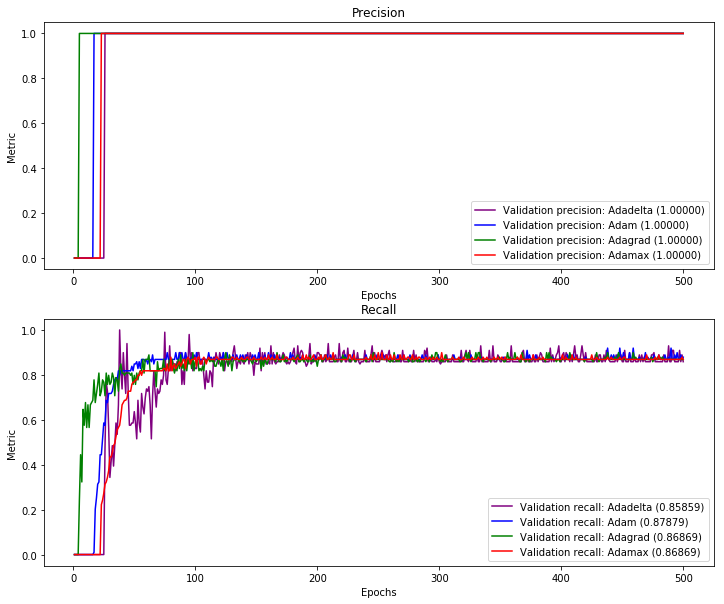

In [24]:
adadelta_adagrad_adam_adamax_colorDict = {'adadelta': ['purple'],'adagrad': ['green'],'adam': ['blue'], 'adamax': ['red']}
plot_history_groupbyMetric(all_ada_results, adadelta_adagrad_adam_adamax_colorDict, alignment='vertical')

In [ ]:
adadelta_adam_results = run_optimizerTest(optimizers=['adadelta', 'adam'], epochs=100, batchSize=32, validationSplit=0.1)

Train on 885 samples, validate on 99 samples
Epoch 1/100
885/885 [==============================] - 10s 11ms/step - loss: 0.6917 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7230 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
885/885 [==============================] - 0s 300us/step - loss: 0.6893 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
885/885 [==============================] - 0s 285us/step - loss: 0.6874 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7797 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
885/885 [==============================] - 0s 193us/step - loss: 0.6847 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
885/885 [==============================] - 0s 187us/step - loss: 0.6693 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7641 - v

544/885 [=================>............] - ETA: 0s - loss: 0.2401 - precision: 0.9787 - recall: 0.9004

In [ ]:
adadelta_adam_colorDict = {'adam': ['blue'], 'adadelta': ['purple']}
plot_history_groupbyMetric(adadelta_adam_results, adadelta_adam_colorDict, alignment='vertical')

In [63]:
optimizer_result_dict_adagrad_adadelta_adam_sgd = run_optimizerTest(optimizers=['adagrad','adadelta', 'adam', 'sgd'], epoches=100, batchSize=32, validationSplit=0.1)

Train on 885 samples, validate on 99 samples
Epoch 1/100


KeyboardInterrupt: 

/home/machinator/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


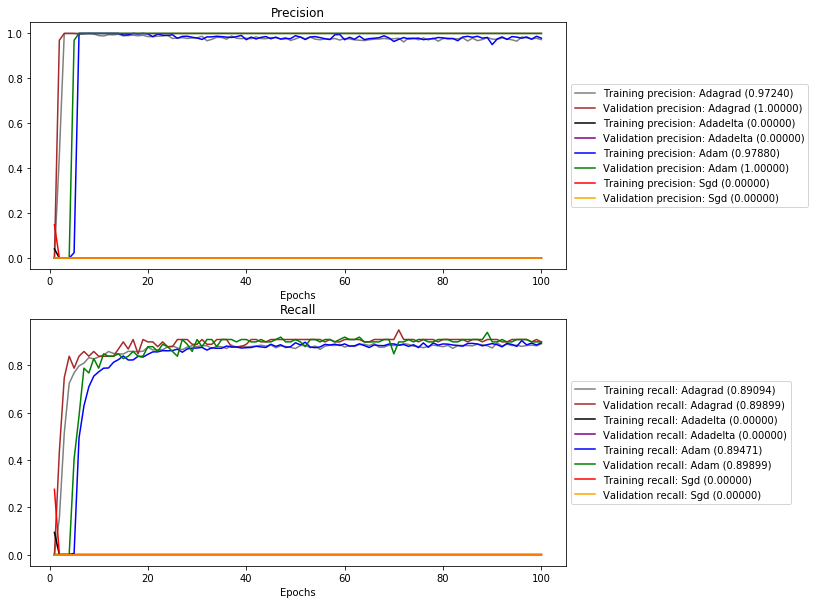

In [246]:
adagrad_adadelta_adam_sgd_colorDict = {'adam': ['blue', 'green'], 'sgd': ['red', 'orange'], 'adadelta': ['black', 'purple'], 'adagrad': ['gray', 'brown']}
plot_history_groupbyMetric(optimizer_result_dict_adagrad_adadelta_adam_sgd, adagrad_adadelta_adam_sgd_colorDict, alignment='vertical')

In [256]:
optimizer_result_dict_adagrad_adadelta_adam_sgd_1000 = run_optimizerTest(optimizers=['adagrad','adadelta', 'adam'], epoches=100, batchSize=32, validationSplit=0.2)

Train on 787 samples, validate on 197 samples
Epoch 1/100
787/787 [==============================] - 19s 24ms/step - loss: 0.6739 - precision: 0.0089 - recall: 0.0407 - val_loss: 0.9576 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
787/787 [==============================] - 0s 322us/step - loss: 0.6334 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
787/787 [==============================] - 0s 324us/step - loss: 0.5768 - precision: 0.6747 - recall: 0.1581 - val_loss: 0.9015 - val_precision: 1.0000 - val_recall: 0.3147
Epoch 4/100
787/787 [==============================] - 0s 359us/step - loss: 0.4600 - precision: 0.9919 - recall: 0.5303 - val_loss: 0.4687 - val_precision: 1.0000 - val_recall: 0.7970
Epoch 5/100
787/787 [==============================] - 0s 383us/step - loss: 0.3571 - precision: 1.0000 - recall: 0.7130 - val_loss: 0.4790 - val_precision: 1.0000 - val_recall: 0.7919
Epoch

Epoch 45/100
787/787 [==============================] - 0s 474us/step - loss: 0.1675 - precision: 0.9963 - recall: 0.8749 - val_loss: 0.1764 - val_precision: 1.0000 - val_recall: 0.9086
Epoch 46/100
787/787 [==============================] - 0s 315us/step - loss: 0.1732 - precision: 0.9826 - recall: 0.8691 - val_loss: 0.2668 - val_precision: 1.0000 - val_recall: 0.8731
Epoch 47/100
787/787 [==============================] - 0s 334us/step - loss: 0.1693 - precision: 0.9819 - recall: 0.8782 - val_loss: 0.2665 - val_precision: 1.0000 - val_recall: 0.8731
Epoch 48/100
787/787 [==============================] - 0s 356us/step - loss: 0.1673 - precision: 0.9890 - recall: 0.8772 - val_loss: 0.2720 - val_precision: 1.0000 - val_recall: 0.8731
Epoch 49/100
787/787 [==============================] - 0s 319us/step - loss: 0.1643 - precision: 0.9922 - recall: 0.8758 - val_loss: 0.2036 - val_precision: 1.0000 - val_recall: 0.9036
Epoch 50/100
787/787 [==============================] - 0s 331us/step 

787/787 [==============================] - 0s 377us/step - loss: 0.1596 - precision: 0.9852 - recall: 0.8795 - val_loss: 0.2721 - val_precision: 1.0000 - val_recall: 0.8832
Epoch 90/100
787/787 [==============================] - 0s 507us/step - loss: 0.1605 - precision: 0.9798 - recall: 0.8800 - val_loss: 0.3073 - val_precision: 1.0000 - val_recall: 0.8782
Epoch 91/100
787/787 [==============================] - 0s 504us/step - loss: 0.1611 - precision: 0.9732 - recall: 0.8771 - val_loss: 0.2447 - val_precision: 1.0000 - val_recall: 0.8934
Epoch 92/100
787/787 [==============================] - 0s 402us/step - loss: 0.1580 - precision: 0.9730 - recall: 0.8743 - val_loss: 0.2754 - val_precision: 1.0000 - val_recall: 0.8832
Epoch 93/100
787/787 [==============================] - 0s 314us/step - loss: 0.1576 - precision: 0.9853 - recall: 0.8754 - val_loss: 0.2651 - val_precision: 1.0000 - val_recall: 0.8883
Epoch 94/100
787/787 [==============================] - 0s 317us/step - loss: 0.157

787/787 [==============================] - 0s 465us/step - loss: 0.1542 - precision: 0.9824 - recall: 0.8743 - val_loss: 0.2591 - val_precision: 1.0000 - val_recall: 0.8832
Epoch 77/100
787/787 [==============================] - 0s 428us/step - loss: 0.1525 - precision: 0.9778 - recall: 0.8735 - val_loss: 0.2621 - val_precision: 1.0000 - val_recall: 0.8832
Epoch 78/100
787/787 [==============================] - 0s 452us/step - loss: 0.1596 - precision: 0.9816 - recall: 0.8737 - val_loss: 0.2182 - val_precision: 1.0000 - val_recall: 0.8985
Epoch 79/100
787/787 [==============================] - 0s 478us/step - loss: 0.1564 - precision: 0.9755 - recall: 0.8885 - val_loss: 0.4030 - val_precision: 1.0000 - val_recall: 0.8528
Epoch 80/100
787/787 [==============================] - 0s 560us/step - loss: 0.1520 - precision: 0.9841 - recall: 0.8760 - val_loss: 0.3354 - val_precision: 1.0000 - val_recall: 0.8731
Epoch 81/100
787/787 [==============================] - 0s 574us/step - loss: 0.158

787/787 [==============================] - 0s 539us/step - loss: 0.1554 - precision: 0.9764 - recall: 0.8842 - val_loss: 0.2645 - val_precision: 1.0000 - val_recall: 0.8832
Epoch 64/100
787/787 [==============================] - 0s 327us/step - loss: 0.1506 - precision: 0.9843 - recall: 0.8740 - val_loss: 0.1557 - val_precision: 1.0000 - val_recall: 0.9137
Epoch 65/100
787/787 [==============================] - 0s 361us/step - loss: 0.1588 - precision: 0.9547 - recall: 0.8882 - val_loss: 0.3177 - val_precision: 1.0000 - val_recall: 0.8832
Epoch 66/100
787/787 [==============================] - 0s 358us/step - loss: 0.1765 - precision: 0.9646 - recall: 0.8915 - val_loss: 0.4976 - val_precision: 1.0000 - val_recall: 0.8528
Epoch 67/100
787/787 [==============================] - 0s 378us/step - loss: 0.1596 - precision: 0.9785 - recall: 0.8835 - val_loss: 0.2035 - val_precision: 1.0000 - val_recall: 0.9036
Epoch 68/100
787/787 [==============================] - 0s 323us/step - loss: 0.151

/home/machinator/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


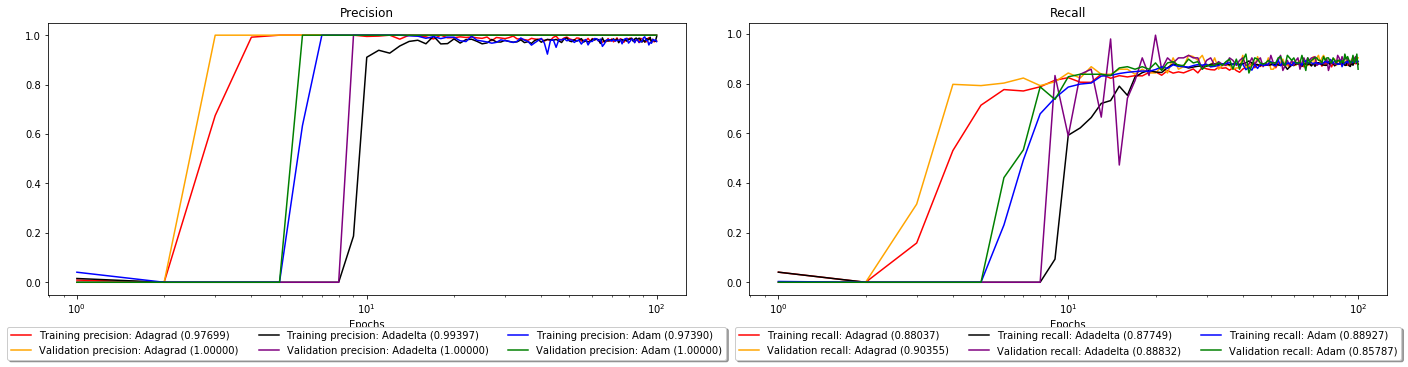

In [71]:
gd_2 = run_optimizerTest(optimizers=['adagrad','adadelta', 'adam'], epoches=100, batchSize=10, validationSplit=0.1)

Train on 885 samples, validate on 99 samples
Epoch 1/100
885/885 [==============================] - 16s 18ms/step - loss: 0.6490 - precision: 0.0497 - recall: 0.0281 - val_loss: 0.8787 - val_precision: 1.0000 - val_recall: 0.3030
Epoch 2/100
885/885 [==============================] - 0s 542us/step - loss: 0.4611 - precision: 0.9548 - recall: 0.6495 - val_loss: 0.7128 - val_precision: 1.0000 - val_recall: 0.6869
Epoch 3/100
885/885 [==============================] - 0s 480us/step - loss: 0.2933 - precision: 0.9962 - recall: 0.8054 - val_loss: 0.5082 - val_precision: 1.0000 - val_recall: 0.7778
Epoch 4/100
885/885 [==============================] - 0s 480us/step - loss: 0.2387 - precision: 0.9774 - recall: 0.8036 - val_loss: 0.2449 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 5/100
885/885 [==============================] - 0s 490us/step - loss: 0.2218 - precision: 0.9846 - recall: 0.8337 - val_loss: 0.1971 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 6/100
885/885 [=========

Epoch 45/100
885/885 [==============================] - 1s 566us/step - loss: 0.1550 - precision: 0.9744 - recall: 0.8948 - val_loss: 0.4073 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 46/100
885/885 [==============================] - 1s 767us/step - loss: 0.1576 - precision: 0.9700 - recall: 0.8901 - val_loss: 0.3537 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 47/100
885/885 [==============================] - 0s 468us/step - loss: 0.1566 - precision: 0.9641 - recall: 0.8876 - val_loss: 0.3862 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 48/100
885/885 [==============================] - 0s 485us/step - loss: 0.1583 - precision: 0.9800 - recall: 0.9057 - val_loss: 0.3733 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 49/100
885/885 [==============================] - 0s 483us/step - loss: 0.1459 - precision: 0.9750 - recall: 0.9019 - val_loss: 0.2025 - val_precision: 1.0000 - val_recall: 0.8788
Epoch 50/100
885/885 [==============================] - 1s 667us/step 

885/885 [==============================] - 0s 467us/step - loss: 0.1479 - precision: 0.9870 - recall: 0.8996 - val_loss: 0.4158 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 90/100
885/885 [==============================] - 0s 464us/step - loss: 0.1491 - precision: 0.9720 - recall: 0.8975 - val_loss: 0.3648 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 91/100
885/885 [==============================] - 0s 467us/step - loss: 0.1472 - precision: 0.9886 - recall: 0.9004 - val_loss: 0.2656 - val_precision: 1.0000 - val_recall: 0.8687
Epoch 92/100
885/885 [==============================] - 0s 480us/step - loss: 0.1498 - precision: 0.9798 - recall: 0.9105 - val_loss: 0.3841 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 93/100
885/885 [==============================] - 0s 553us/step - loss: 0.1483 - precision: 0.9840 - recall: 0.9019 - val_loss: 0.3645 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 94/100
885/885 [==============================] - 0s 529us/step - loss: 0.148

Epoch 33/100
885/885 [==============================] - 0s 499us/step - loss: 0.1563 - precision: 0.9760 - recall: 0.9072 - val_loss: 0.3636 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 34/100
885/885 [==============================] - 0s 491us/step - loss: 0.1569 - precision: 0.9858 - recall: 0.9022 - val_loss: 0.4291 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 35/100
885/885 [==============================] - 0s 491us/step - loss: 0.1516 - precision: 0.9707 - recall: 0.8963 - val_loss: 0.2713 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 36/100
885/885 [==============================] - 0s 559us/step - loss: 0.1542 - precision: 0.9669 - recall: 0.8854 - val_loss: 0.2964 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 37/100
885/885 [==============================] - 0s 493us/step - loss: 0.1488 - precision: 0.9689 - recall: 0.9042 - val_loss: 0.3205 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 38/100
885/885 [==============================] - 0s 498us/step 

885/885 [==============================] - 0s 501us/step - loss: 0.1452 - precision: 0.9835 - recall: 0.9095 - val_loss: 0.4336 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 78/100
885/885 [==============================] - 0s 483us/step - loss: 0.1446 - precision: 0.9785 - recall: 0.8962 - val_loss: 0.4739 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 79/100
885/885 [==============================] - 0s 476us/step - loss: 0.1453 - precision: 0.9713 - recall: 0.8919 - val_loss: 0.2869 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 80/100
885/885 [==============================] - 0s 481us/step - loss: 0.1401 - precision: 0.9911 - recall: 0.9047 - val_loss: 0.4424 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 81/100
885/885 [==============================] - 0s 479us/step - loss: 0.1437 - precision: 0.9887 - recall: 0.9016 - val_loss: 0.4038 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 82/100
885/885 [==============================] - 0s 488us/step - loss: 0.145

Epoch 21/100
885/885 [==============================] - 0s 519us/step - loss: 0.1647 - precision: 0.9741 - recall: 0.9017 - val_loss: 0.3774 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 22/100
885/885 [==============================] - 0s 490us/step - loss: 0.1541 - precision: 0.9737 - recall: 0.8945 - val_loss: 0.4729 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 23/100
885/885 [==============================] - 0s 495us/step - loss: 0.1669 - precision: 0.9633 - recall: 0.8987 - val_loss: 0.4673 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 24/100
885/885 [==============================] - 0s 489us/step - loss: 0.1597 - precision: 0.9640 - recall: 0.9014 - val_loss: 0.3372 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 25/100
885/885 [==============================] - 0s 490us/step - loss: 0.1526 - precision: 0.9791 - recall: 0.9006 - val_loss: 0.3136 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 26/100
885/885 [==============================] - 0s 493us/step 

885/885 [==============================] - 1s 583us/step - loss: 0.1476 - precision: 0.9902 - recall: 0.9074 - val_loss: 0.1165 - val_precision: 1.0000 - val_recall: 0.9495
Epoch 66/100
885/885 [==============================] - 1s 589us/step - loss: 0.1641 - precision: 0.9577 - recall: 0.8953 - val_loss: 0.2784 - val_precision: 1.0000 - val_recall: 0.8586
Epoch 67/100
885/885 [==============================] - 0s 531us/step - loss: 0.1506 - precision: 0.9610 - recall: 0.8950 - val_loss: 0.4331 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 68/100
885/885 [==============================] - 1s 602us/step - loss: 0.1570 - precision: 0.9812 - recall: 0.9111 - val_loss: 0.4802 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 69/100
885/885 [==============================] - 0s 520us/step - loss: 0.1468 - precision: 0.9679 - recall: 0.8855 - val_loss: 0.4272 - val_precision: 1.0000 - val_recall: 0.8485
Epoch 70/100
885/885 [==============================] - 0s 557us/step - loss: 0.143

/home/machinator/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


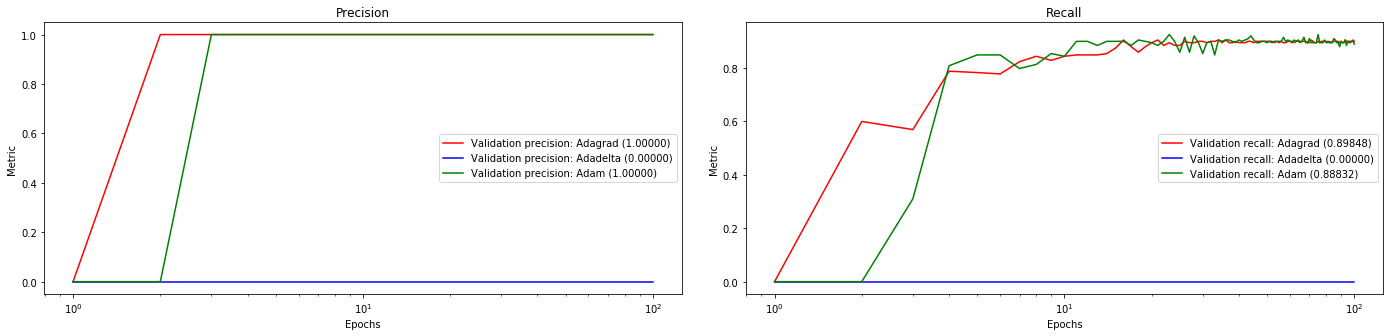

In [69]:
adagrad_adadelta_adam_colorDict = {'adam': ['green'], 'adadelta': ['blue'], 'adagrad': ['red']}
plot_history_groupbyMetric(gd_2, adagrad_adadelta_adam_colorDict, x_scale='log', alignment='horizontal')

In [ ]:
optimizer_result_dict_2000 = run_optimizerTest(optimizers=['adam', 'sgd'], epoches=2000, batchSize=10, validationSplit=0.1)

In [ ]:
adam_adadelta_colorDict = {'adam': ['blue', 'green'], 'sgd': ['black', 'purple']}
plot_history_groupbyMetric(optimizer_result_dict_2000, adam_adadelta_colorDict, alignment='vertical')